normal vs removing stop words

In [1]:
import pandas as pd
import numpy as np
import os
import random
import torch
import pickle
import utilities
from tqdm import tqdm
import preprocess
import similarities
import parameters
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations, product

from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader

In [2]:
result_file_name = 'embedding_tuning_opp115-7.p'

In [3]:
random_state = parameters.random_state
np.random.seed(random_state)
data_paths = parameters.data_paths
all_sentence_embeddings =  parameters.huggingface_embeddings + parameters.google_embeddings

In [4]:
data = 'opp115'
df = utilities.read_data(data_paths[data])
X = df['text'].apply(preprocess.preprocess_text)
y = df.drop(['text'], axis=1)
X_stop = X.apply(preprocess.remove_stopwords)

In [5]:
def calculate_between_class_similarities(col1, col2, X, y):
    
    sims = []
    
    for idx1 in y[y[col1]==1].index:
        for idx2 in y[y[col2]==1].index:
            sims.append(similarities.vector_similarity(X.loc[idx1], X.loc[idx2]))
    
    return sum(sims)/len(sims)     

In [6]:
def calculate_similarity_matrix(X, y, sim_method='cosine'):
    
    import similarities
    
    sim_df = pd.DataFrame(index=y.columns, columns=y.columns)
    
    for col in y.columns:
        sim_df.loc[col, col] = similarities.calculate_similarity_within_classes(X.loc[y[y[col]==1].index], sim_calculation_type='average')
    
    for col1, col2 in list(combinations(y.columns, 2)):
        sim_df.loc[col1, col2] = similarities.calculate_similarity_between_classes(X.loc[y[y[col1]==1].index], X.loc[y[y[col2]==1].index], sim_calculation_type='average')
    
    return sim_df

In [7]:
def calculate_matrix_score(sim_df):
    scores = []
    for col in sim_df.columns:
        scores.append((sim_df.loc[col, col] - sim_df.loc[col].drop(col).max())/sim_df.loc[col, col])
    return scores

In [8]:
def vectorize_data(text, model):
    
    # model = SentenceTransformer(model_name)
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    vectors = model.encode(text, convert_to_tensor=False, device=device)
    
    return vectors

In [9]:
def create_train_data(X, y, samples):
    
    train_set = []

    for col in y.columns:

        idxs = y[y[col]==1].index
        tmp_set = X.loc[idxs].sample(samples[col])

        for pair in combinations(tmp_set, 2):
            train_set.append(InputExample(texts=list(pair), label=1.0))

    for col1, col2 in combinations(y.columns,2):
        
        sample_num = samples[(col1, col2)]
        idxs1 = y[(y[col1]==1)&(y[col2]==0)].index
        idxs2 = y[(y[col2]==1)&(y[col1]==0)].index
        tmp_samples = random.sample(list(product(idxs1, idxs2)), sample_num)
        
        tmp_set1 = X.loc[[i[0] for i in tmp_samples]]
        tmp_set2 = X.loc[[i[1] for i in tmp_samples]]
        
        for pair in zip(tmp_set1, tmp_set2):
            train_set.append(InputExample(texts=list(pair), label=0.0))

    print(len(train_set))
    
    return train_set

In [10]:
if not os.path.exists(result_file_name):
    results = {}
    with open(result_file_name, 'wb') as f:
        pickle.dump(results, f)

In [11]:
total_samples = dict(y.sum())
total_samples

{'Data Retention': 78,
 'Data Security': 207,
 'Do Not Track': 31,
 'First Party Collection/Use': 1181,
 'International and Specific Audiences': 296,
 'Introductory/Generic': 378,
 'Policy Change': 116,
 'Practice not covered': 129,
 'Privacy contact information': 202,
 'Third Party Sharing/Collection': 931,
 'User Access, Edit and Deletion': 147,
 'User Choice/Control': 352}

In [12]:
def create_initial_samples(within_col, between_col):    
    samples = {}

    for col in y.columns:
        samples[col] = within_col

    for col1, col2 in combinations(y.columns, 2):
        samples[(col1, col2)] = between_col
        
    return samples

In [13]:
def update_sample_sizes(simd_df, samples):
    
    for col1, col2 in combinations(simd_df.columns, 2):
        samples[(col1, col2)] = int((1/(1-simd_df.loc[col1, col2])**2)*samples[(col1, col2)])
        
        if samples[(col1, col2)] > total_samples[col1]*total_samples[col2]:
            samples[(col1, col2)] = int(total_samples[col1]*total_samples[col2])
            
    for col in simd_df.columns:
        samples[col] = int((1/simd_df.loc[col, col])*samples[col])
        if samples[col] > total_samples[col]:
            samples[col] = total_samples[col]
            
    return samples

In [14]:
def fill_symmetry(sim_df):
    for col1, col2 in combinations(sim_df.columns, 2):
        sim_df.loc[col2, col1] = sim_df.loc[col1, col2] 
    return sim_df

In [15]:
def check_stopping(sim_df):
    
    sim_df = fill_symmetry(sim_df)
    
    for col in sim_df.columns:
        if sim_df.loc[col, col] < 1.5*(max(sim_df.loc[col].drop(col))):
            return False
        
    return True

In [16]:
def scoring(sim_df):    
    scores = calculate_matrix_score(sim_df)[:-1]
    print(f'max: {max(scores):.2f}, min: {min(scores):.2f}, avg: {sum(scores)/len(scores):.2f}')

    l_sum = 100*np.diag(sim_df).sum()/12 - (sim_df.sum().sum()-np.diag(sim_df).sum())/66
    print(f'{l_sum:.2f}') 

In [17]:
with open(result_file_name, 'rb') as f:
    results = pickle.load(f)

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

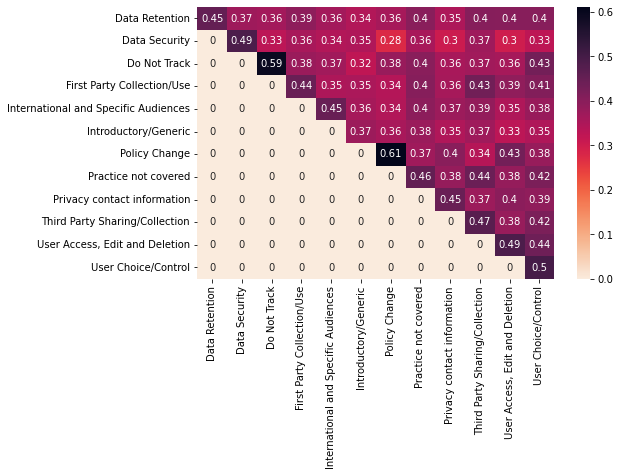

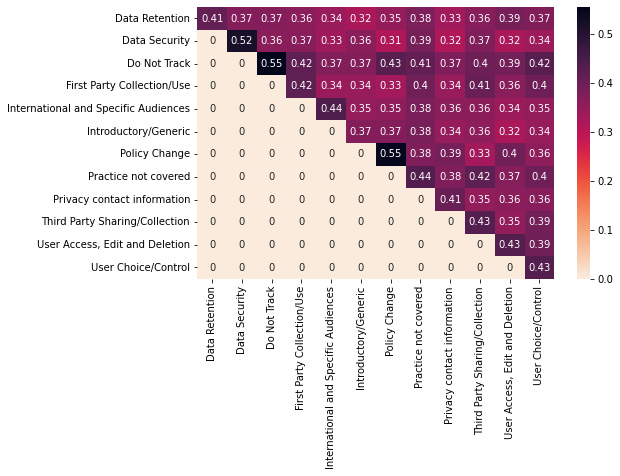

  3%|██▋                                                                             | 1/30 [04:19<2:05:18, 259.26s/it]

****************************************************************************************************
stsb-roberta-large  completed ... 


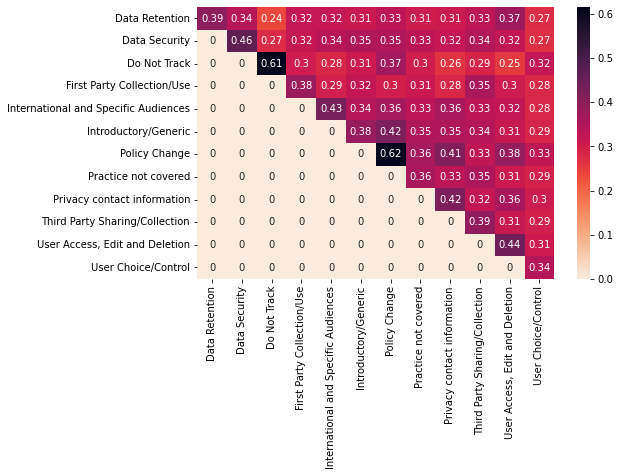

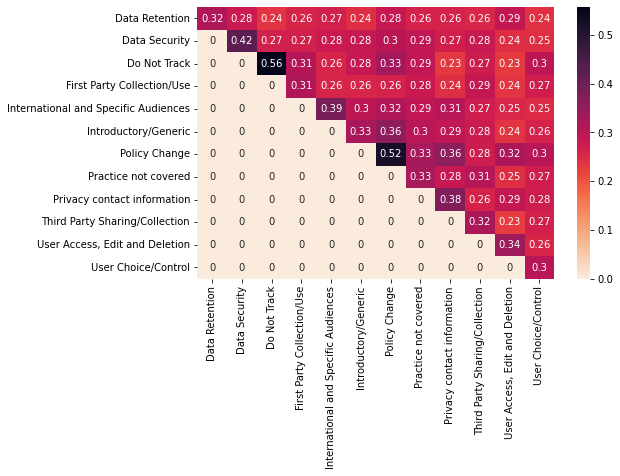

  7%|█████▎                                                                          | 2/30 [05:52<1:15:31, 161.84s/it]

****************************************************************************************************
all-MiniLM-L6-v2  completed ... 


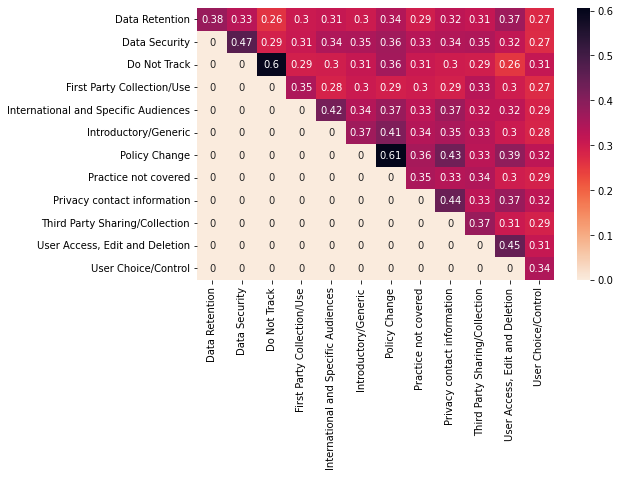

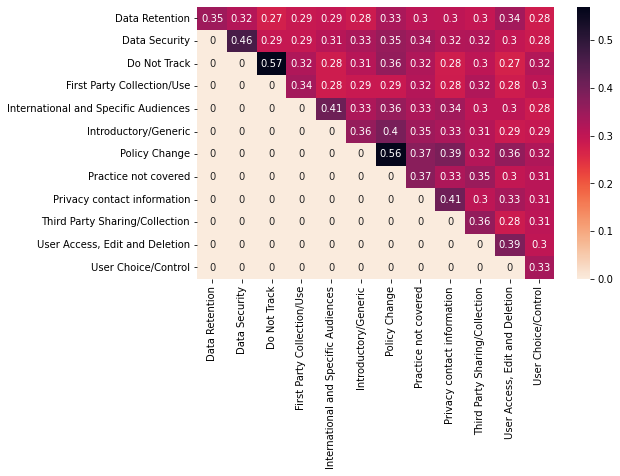

 10%|████████▏                                                                         | 3/30 [07:30<59:33, 132.34s/it]

****************************************************************************************************
all-MiniLM-L12-v2  completed ... 


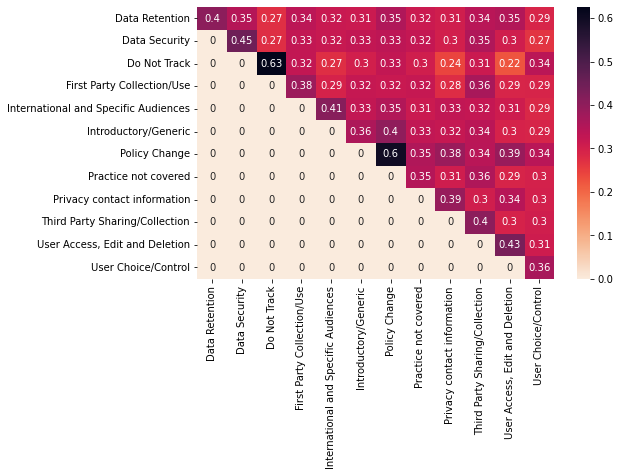

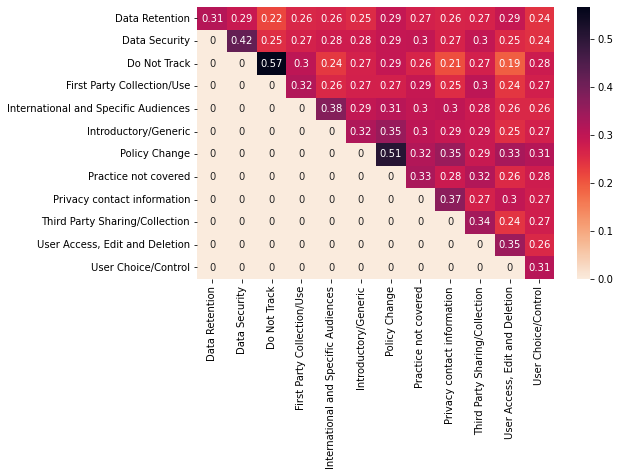

 13%|██████████▋                                                                     | 4/30 [10:28<1:05:12, 150.47s/it]

****************************************************************************************************
all-mpnet-base-v1  completed ... 


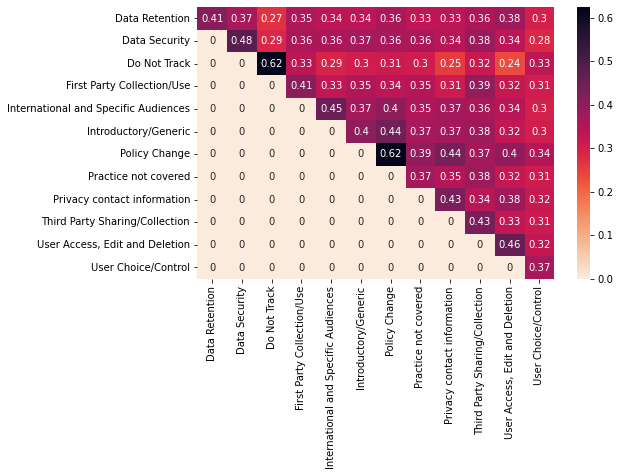

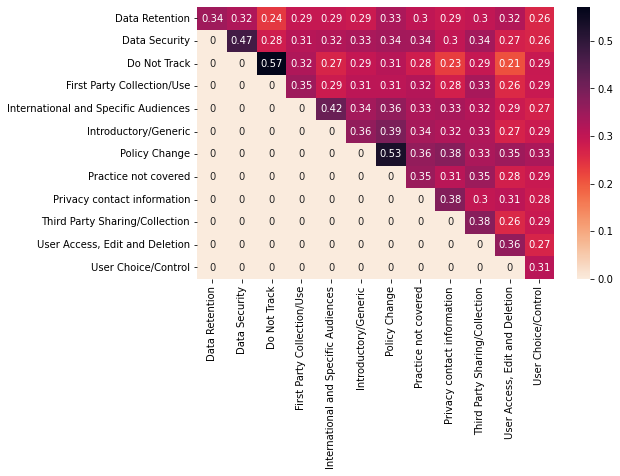

 17%|█████████████▎                                                                  | 5/30 [13:25<1:06:43, 160.12s/it]

****************************************************************************************************
all-mpnet-base-v2  completed ... 


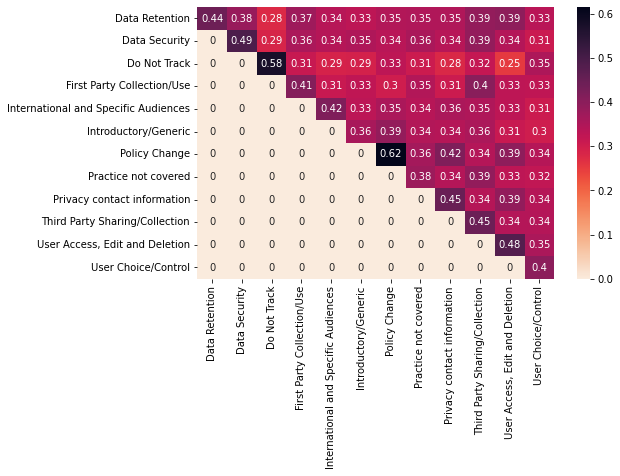

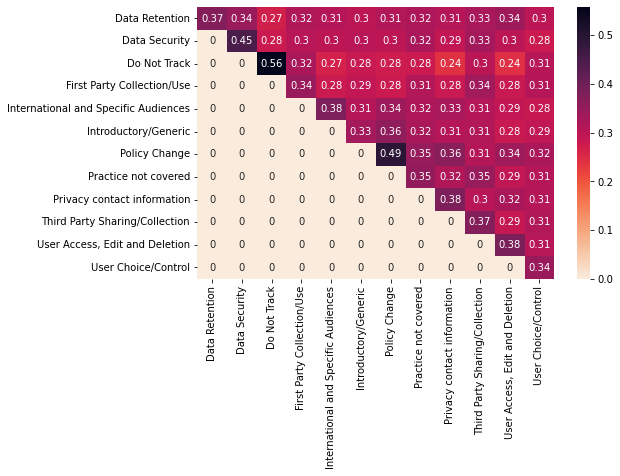

 20%|████████████████                                                                | 6/30 [17:58<1:19:20, 198.35s/it]

****************************************************************************************************
all-roberta-large-v1  completed ... 


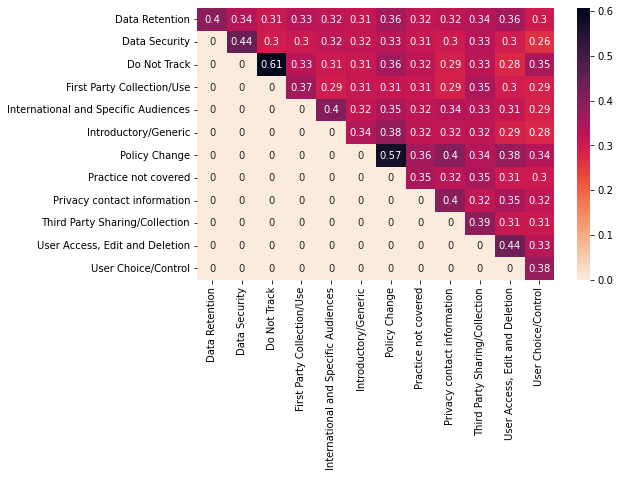

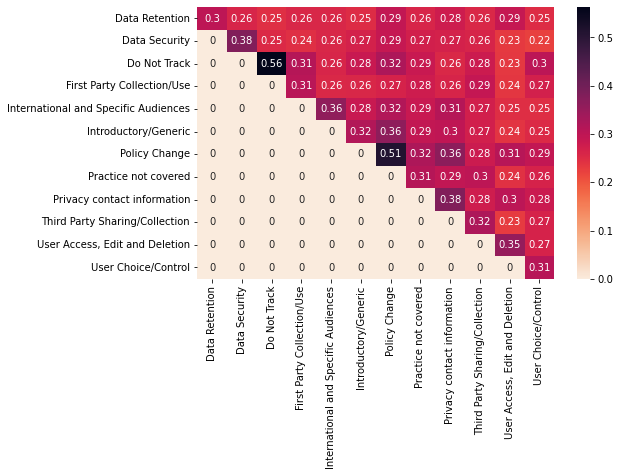

 23%|██████████████████▋                                                             | 7/30 [20:44<1:11:57, 187.72s/it]

****************************************************************************************************
all-distilroberta-v1  completed ... 


Some weights of the model checkpoint at C:\Users\IsmailKaraman/.cache\torch\sentence_transformers\albert-base-v2 were not used when initializing AlbertModel: ['predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


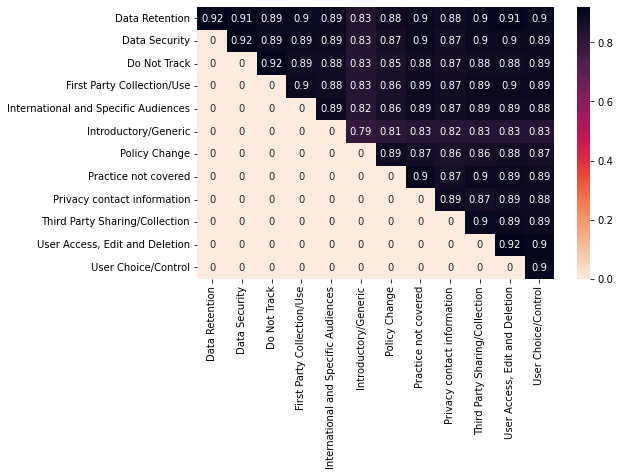

Some weights of the model checkpoint at C:\Users\IsmailKaraman/.cache\torch\sentence_transformers\albert-base-v2 were not used when initializing AlbertModel: ['predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


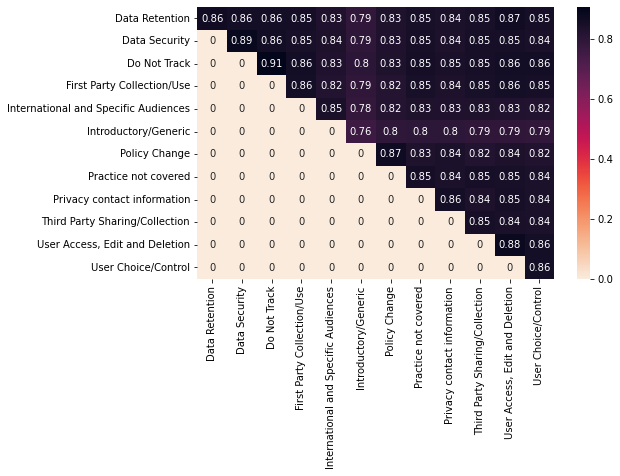

 27%|█████████████████████▎                                                          | 8/30 [23:34<1:06:50, 182.30s/it]

****************************************************************************************************
albert-base-v2  completed ... 


 30%|████████████████████████▌                                                         | 9/30 [23:35<43:56, 125.53s/it]

! ALBERT-xlarge failed due to 404 Client Error: Not Found for url: https://huggingface.co/api/models/sentence-transformers/ALBERT-xlarge... 


 33%|███████████████████████████▎                                                      | 10/30 [23:36<28:59, 86.99s/it]

! ALBERT-xxlarg failed due to 404 Client Error: Not Found for url: https://huggingface.co/api/models/sentence-transformers/ALBERT-xxlarg... 


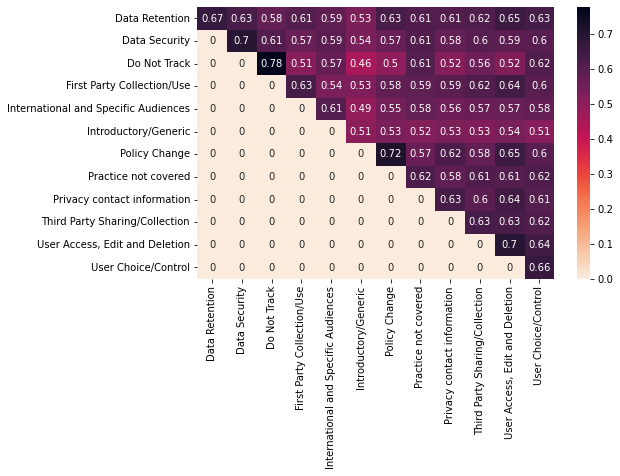

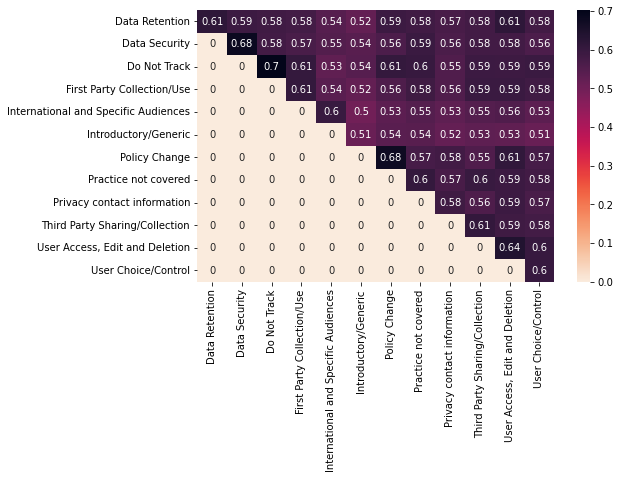

 37%|█████████████████████████████▋                                                   | 11/30 [26:30<36:01, 113.76s/it]

****************************************************************************************************
bert-base-nli-mean-tokens  completed ... 


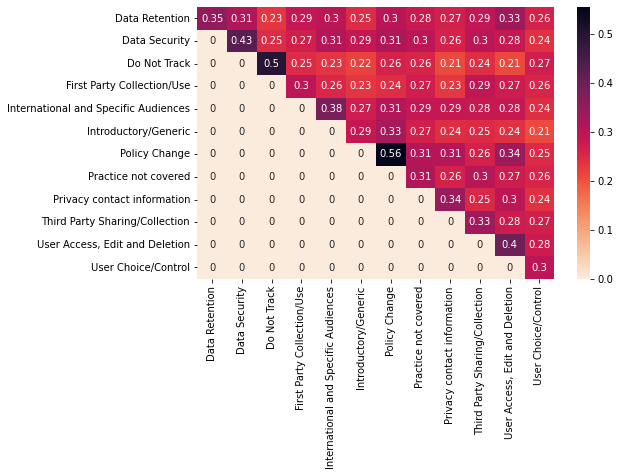

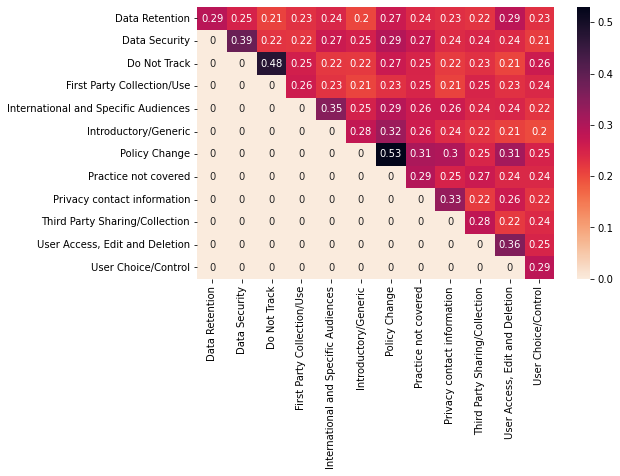

 40%|████████████████████████████████▍                                                | 12/30 [28:42<35:45, 119.22s/it]

****************************************************************************************************
distiluse-base-multilingual-cased-v1  completed ... 


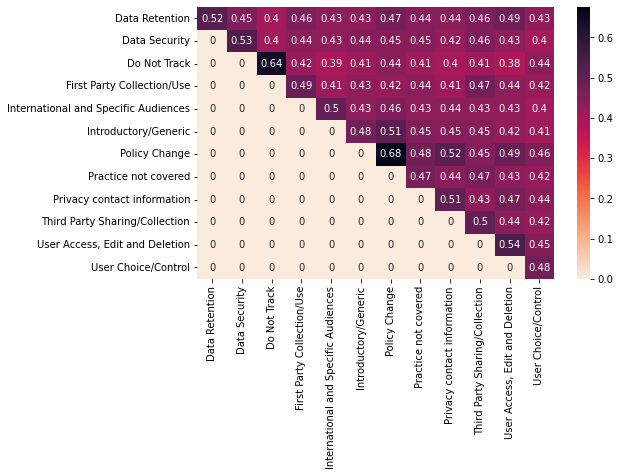

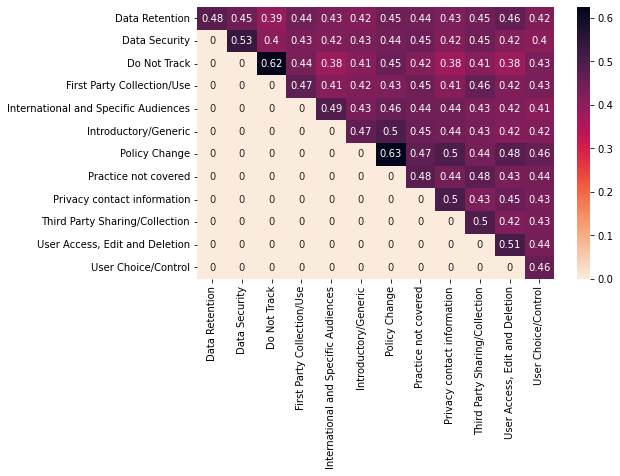

 43%|███████████████████████████████████                                              | 13/30 [31:45<39:17, 138.68s/it]

****************************************************************************************************
multi-qa-mpnet-base-dot-v1  completed ... 


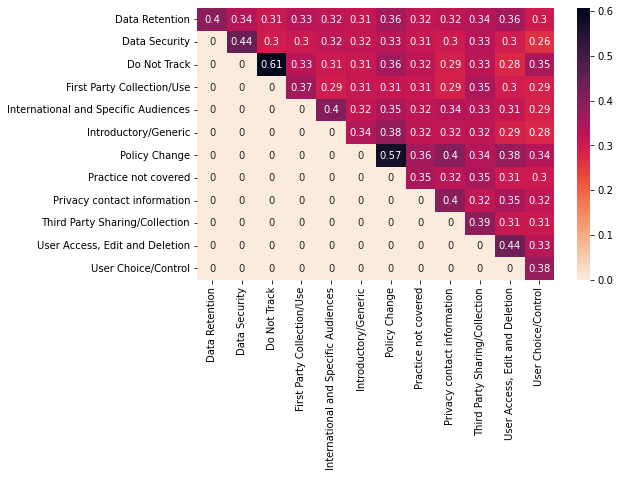

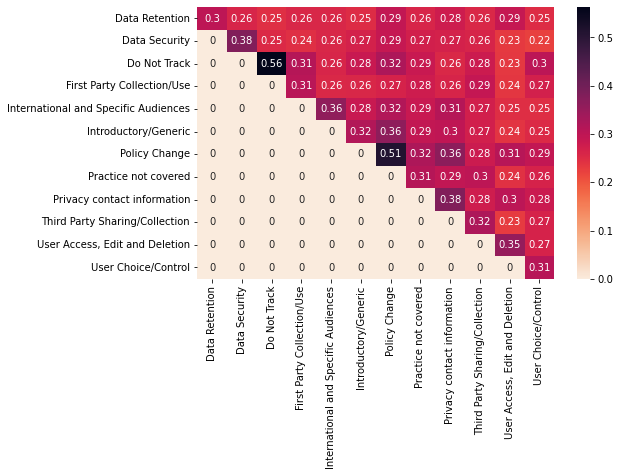

 47%|█████████████████████████████████████▊                                           | 14/30 [34:35<39:29, 148.06s/it]

****************************************************************************************************
all-distilroberta-v1  completed ... 


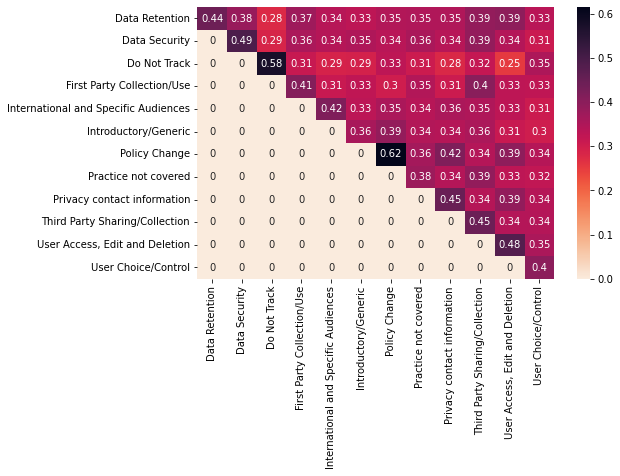

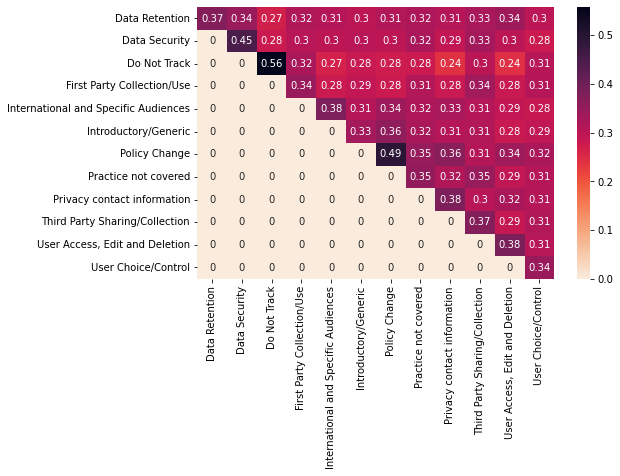

 50%|████████████████████████████████████████▌                                        | 15/30 [39:17<47:05, 188.39s/it]

****************************************************************************************************
all-roberta-large-v1  completed ... 


Some weights of the model checkpoint at C:\Users\IsmailKaraman/.cache\torch\sentence_transformers\bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


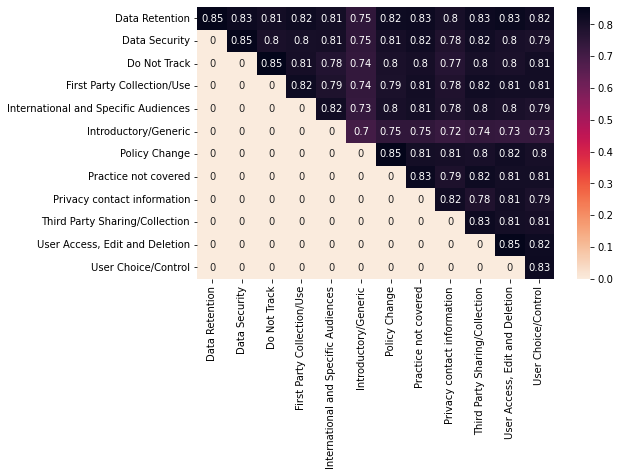

Some weights of the model checkpoint at C:\Users\IsmailKaraman/.cache\torch\sentence_transformers\bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


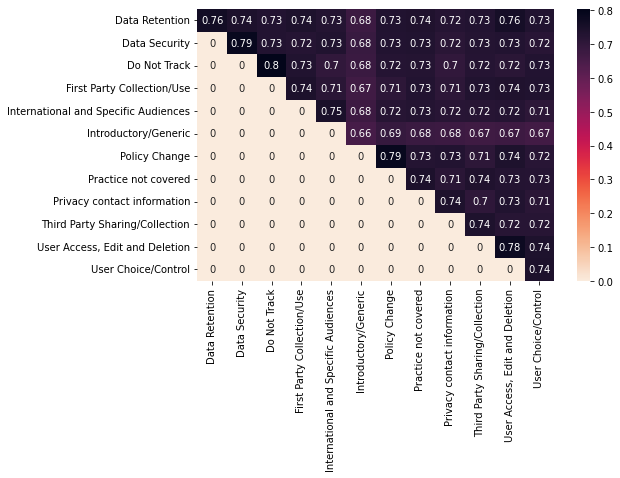

 53%|███████████████████████████████████████████▏                                     | 16/30 [42:10<42:53, 183.79s/it]

****************************************************************************************************
bert-base-uncased  completed ... 


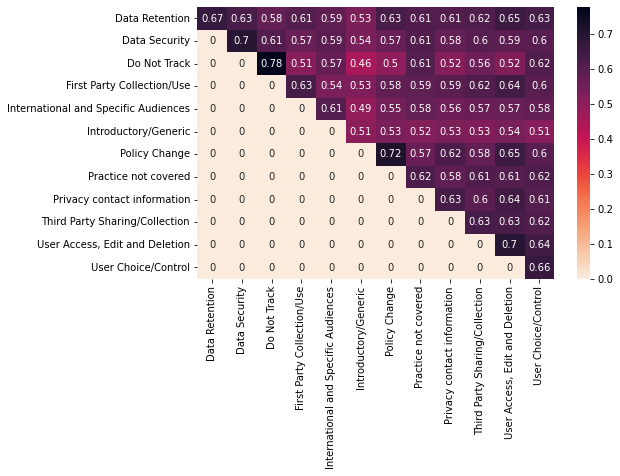

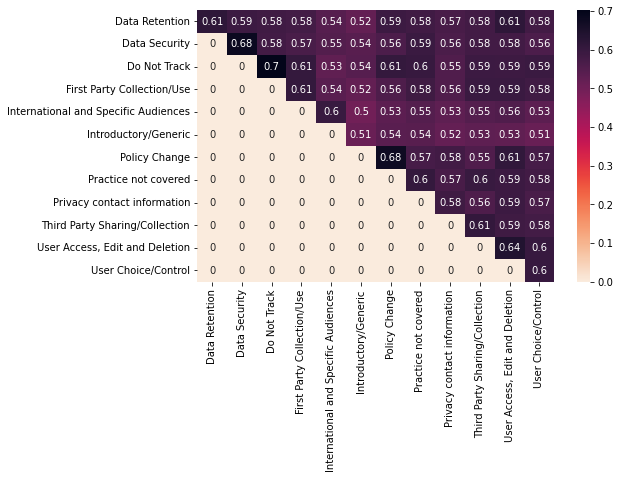

 57%|█████████████████████████████████████████████▉                                   | 17/30 [45:05<39:15, 181.18s/it]

****************************************************************************************************
bert-base-nli-mean-tokens  completed ... 


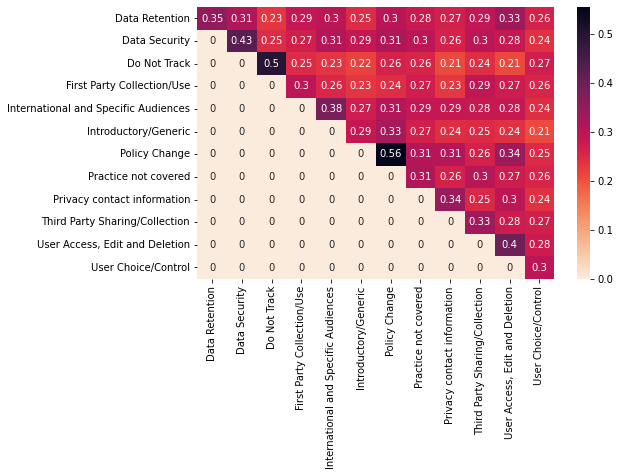

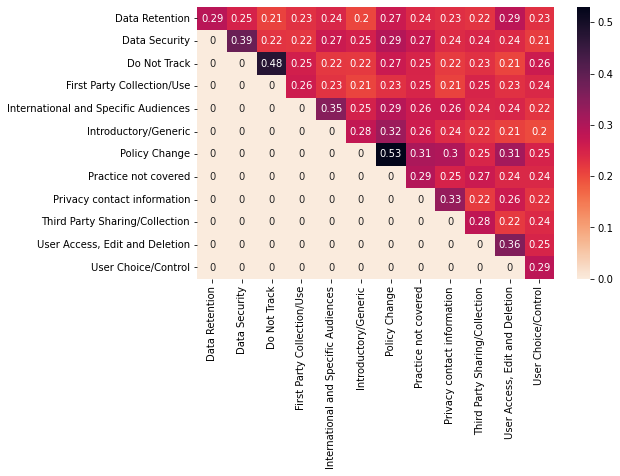

 60%|████████████████████████████████████████████████▌                                | 18/30 [47:15<33:10, 165.89s/it]

****************************************************************************************************
distiluse-base-multilingual-cased-v1  completed ... 


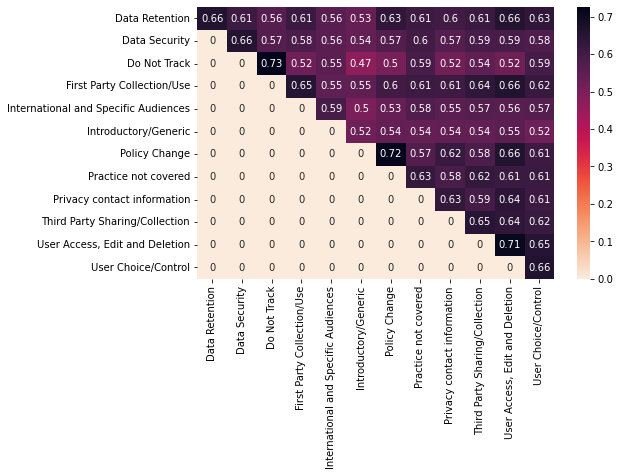

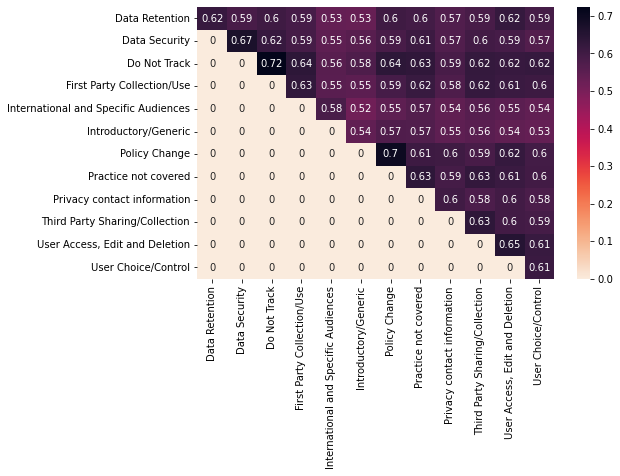

 63%|███████████████████████████████████████████████████▎                             | 19/30 [49:58<30:14, 164.94s/it]

****************************************************************************************************
distilbert-base-nli-mean-tokens  completed ... 


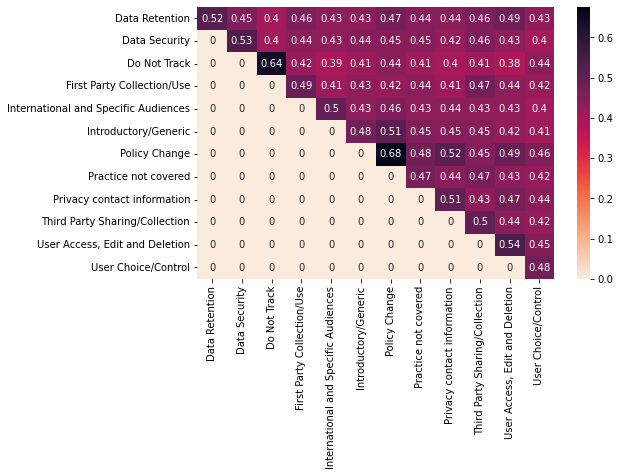

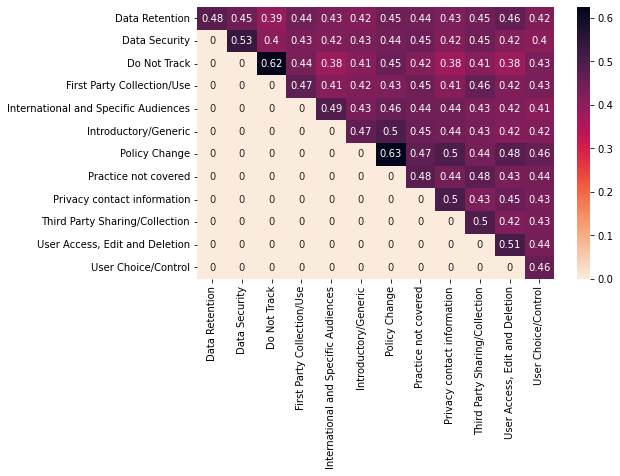

 67%|██████████████████████████████████████████████████████                           | 20/30 [52:59<28:18, 169.86s/it]

****************************************************************************************************
multi-qa-mpnet-base-dot-v1  completed ... 


Some weights of the model checkpoint at C:\Users\IsmailKaraman/.cache\torch\sentence_transformers\nlpaueb_legal-bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


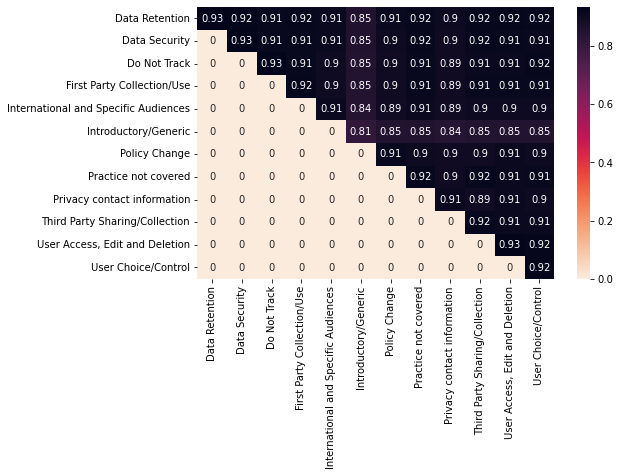

Some weights of the model checkpoint at C:\Users\IsmailKaraman/.cache\torch\sentence_transformers\nlpaueb_legal-bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


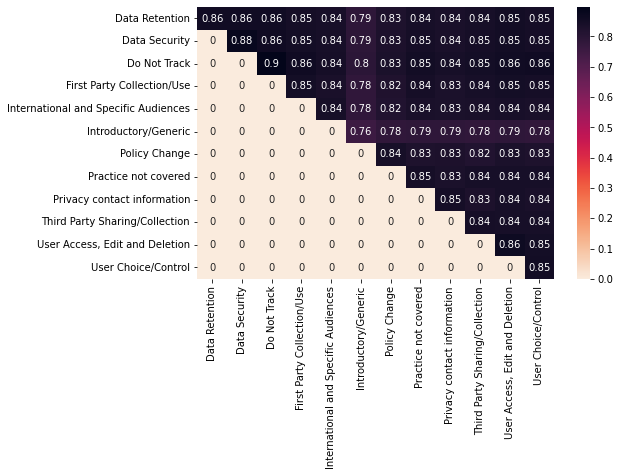

 70%|████████████████████████████████████████████████████████▋                        | 21/30 [55:53<25:38, 170.95s/it]

****************************************************************************************************
nlpaueb/legal-bert-base-uncased  completed ... 


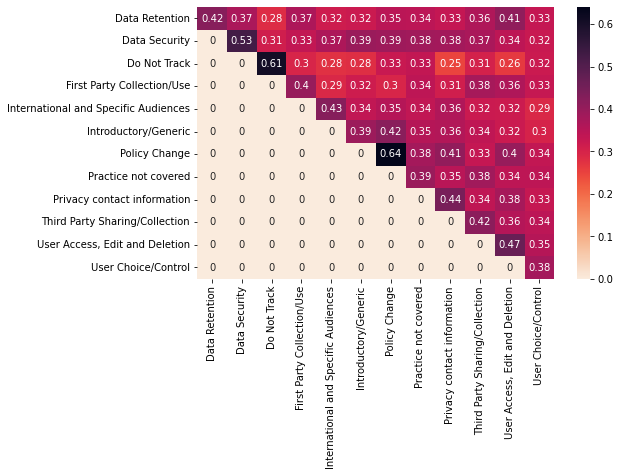

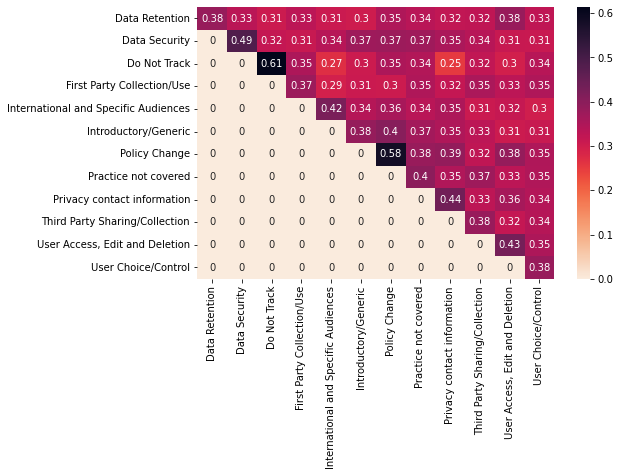

 73%|███████████████████████████████████████████████████████████▍                     | 22/30 [57:35<20:03, 150.42s/it]

****************************************************************************************************
paraphrase-multilingual-MiniLM-L12-v2  completed ... 


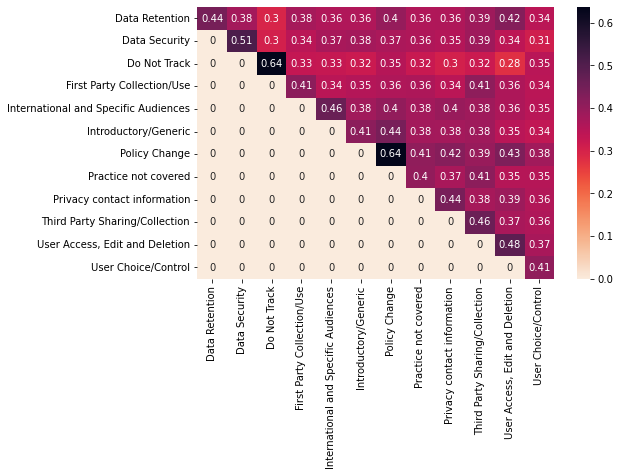

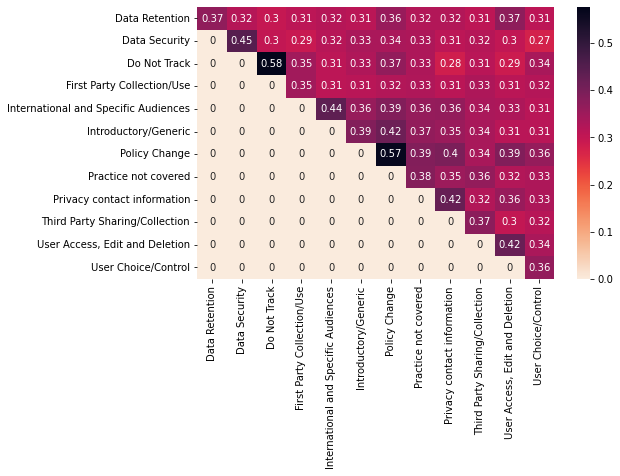

 77%|████████████████████████████████████████████████████████████▌                  | 23/30 [1:00:40<18:45, 160.75s/it]

****************************************************************************************************
paraphrase-mpnet-base-v2  completed ... 


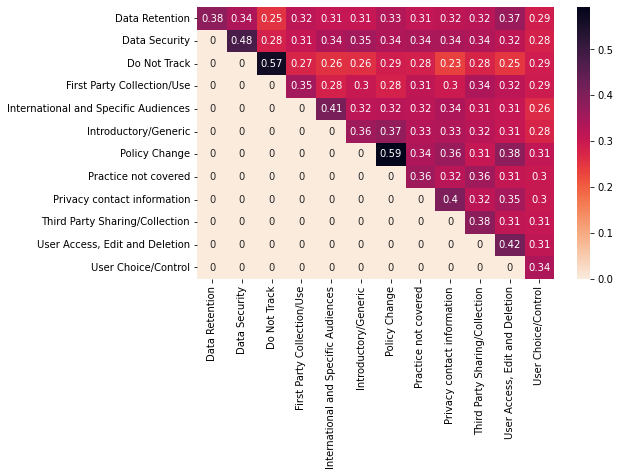

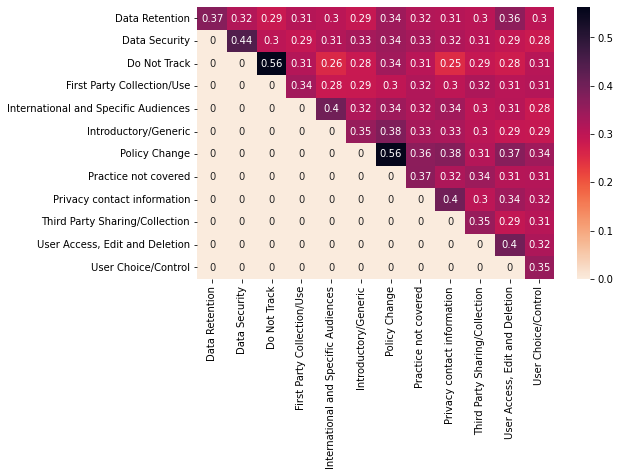

 80%|███████████████████████████████████████████████████████████████▏               | 24/30 [1:02:13<14:01, 140.32s/it]

****************************************************************************************************
paraphrase-MiniLM-L6-v2  completed ... 


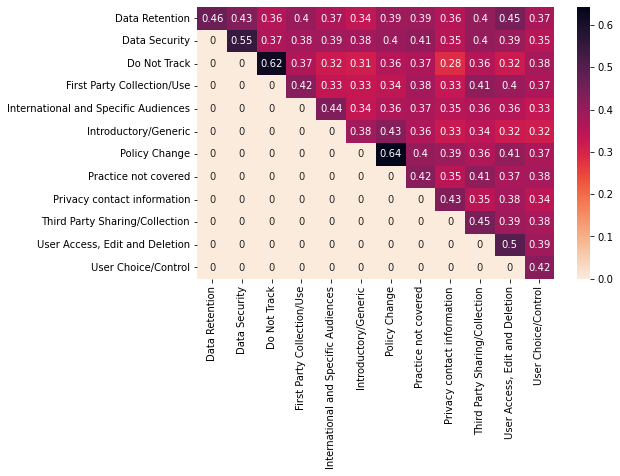

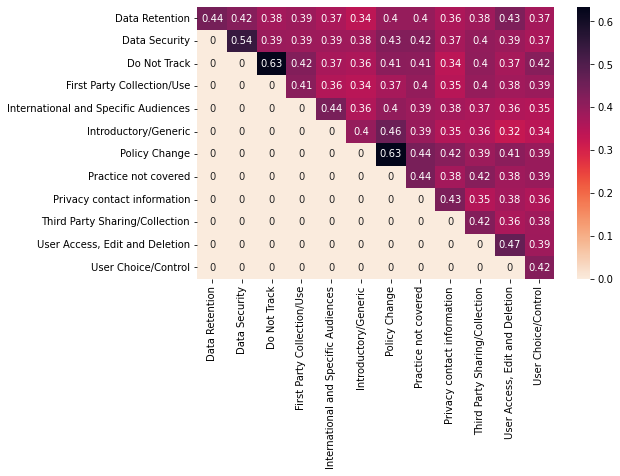

 83%|█████████████████████████████████████████████████████████████████▊             | 25/30 [1:05:25<12:58, 155.69s/it]

****************************************************************************************************
paraphrase-xlm-r-multilingual-v1  completed ... 


Some weights of the model checkpoint at C:\Users\IsmailKaraman/.cache\torch\sentence_transformers\saibo_legal-roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at C:\Users\IsmailKaraman/.cache\torch\sentence_transformers\saibo_legal-roberta-base and are newly initialized: ['roberta.pool

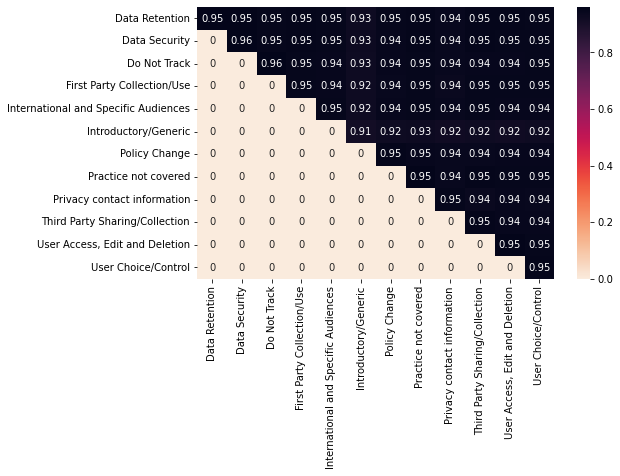

Some weights of the model checkpoint at C:\Users\IsmailKaraman/.cache\torch\sentence_transformers\saibo_legal-roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at C:\Users\IsmailKaraman/.cache\torch\sentence_transformers\saibo_legal-roberta-base and are newly initialized: ['roberta.pool

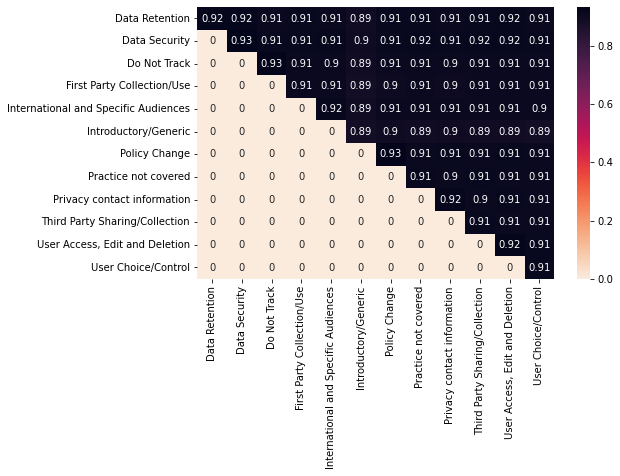

 87%|████████████████████████████████████████████████████████████████████▍          | 26/30 [1:08:27<10:54, 163.64s/it]

****************************************************************************************************
saibo/legal-roberta-base  completed ... 


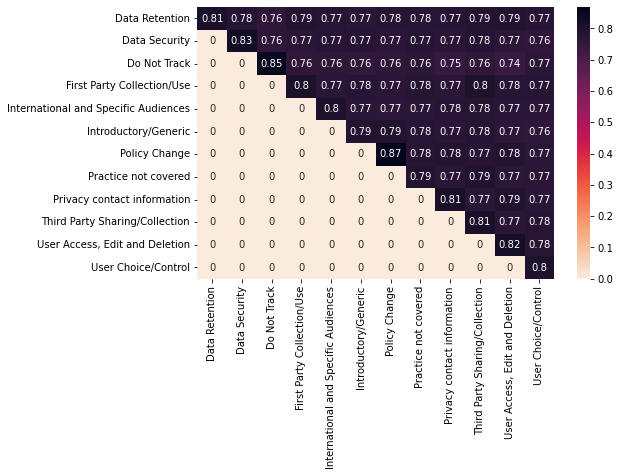

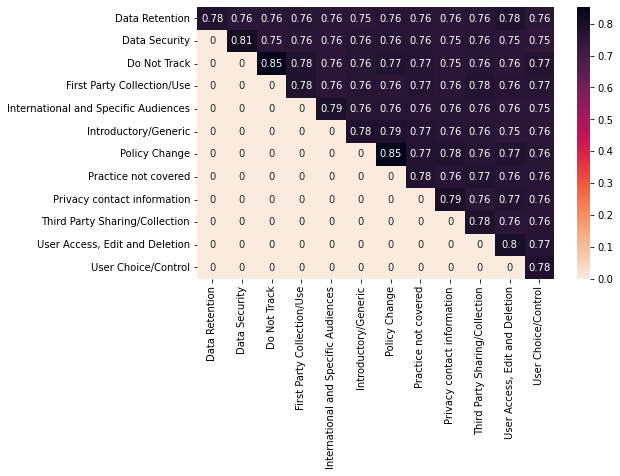

 90%|███████████████████████████████████████████████████████████████████████        | 27/30 [1:12:53<09:43, 194.47s/it]

****************************************************************************************************
sentence-t5-large  completed ... 


C:\Users\IsmailKaraman\workspace\GitHub\thesis\similarities.py:97: RuntimeWarning: invalid value encountered in true_divide
  sims = np.sum(np.multiply(first_part, second_part), axis=1)/(np.multiply(np.linalg.norm(first_part, axis=1), np.linalg.norm(second_part, axis=1)))
C:\Users\IsmailKaraman\workspace\GitHub\thesis\similarities.py:115: RuntimeWarning: invalid value encountered in true_divide
  sims = np.sum(np.multiply(first_part, second_part), axis=1)/(np.multiply(np.linalg.norm(first_part, axis=1), np.linalg.norm(second_part, axis=1)))


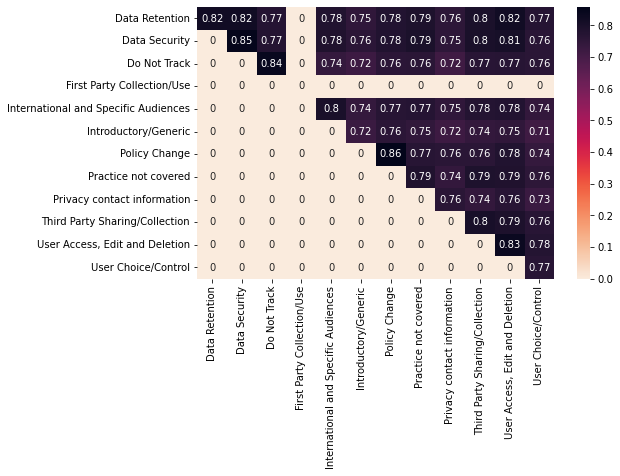

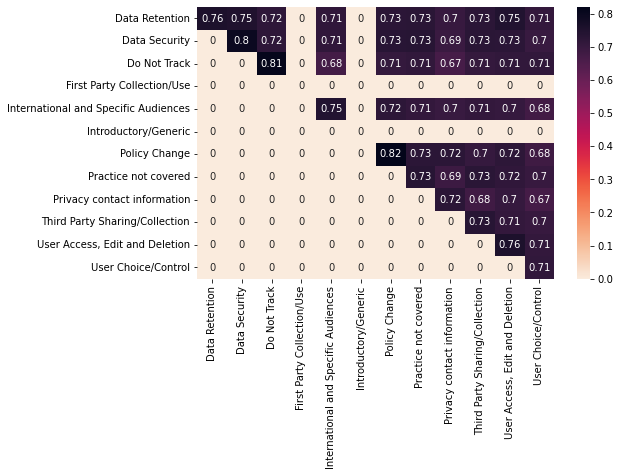

 93%|█████████████████████████████████████████████████████████████████████████▋     | 28/30 [1:14:08<05:16, 158.48s/it]

****************************************************************************************************
sentence-transformers/average_word_embeddings_glove.6B.300d  completed ... 


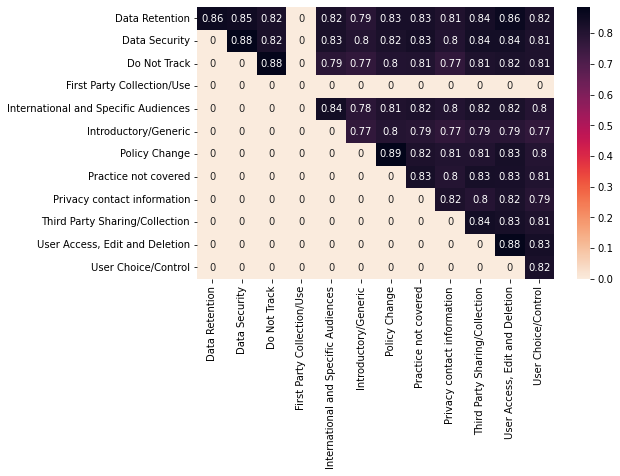

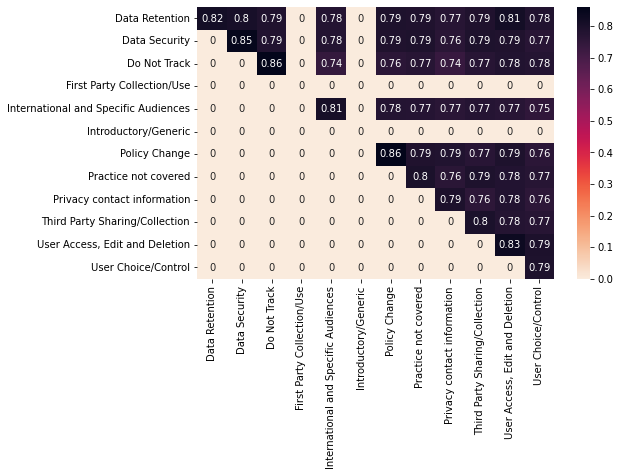

 97%|████████████████████████████████████████████████████████████████████████████▎  | 29/30 [1:15:42<02:19, 139.40s/it]

****************************************************************************************************
sentence-transformers/average_word_embeddings_glove.840B.300d  completed ... 


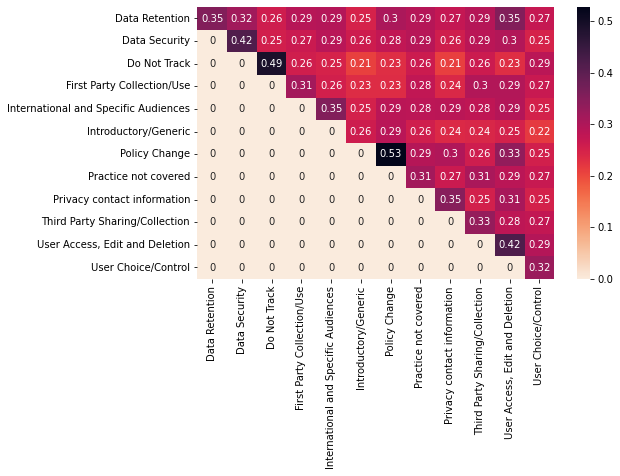

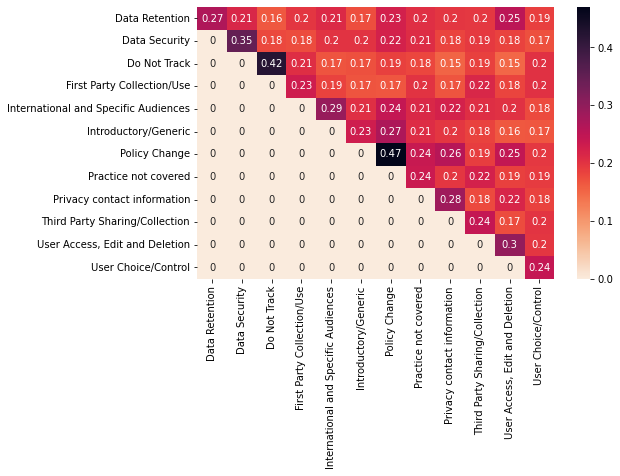

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [1:17:46<00:00, 155.56s/it]

****************************************************************************************************
universal-sentence-encoder  completed ... 


In [18]:
iterate = [i for i in all_sentence_embeddings if i not in results.keys()]
results['failed_embedings'] = []

i= 0

for embedding_method in tqdm(iterate):
    
    try:
        X_num = utilities.vectorize_data(X, embedding_method)
        sim_df = calculate_similarity_matrix(X_num, y)
        results[embedding_method+'_normal'] = sim_df
        plt.figure(2*i, figsize=(8,5)) 
        sns.heatmap(sim_df.fillna(0), annot=True,
                         xticklabels=sim_df.columns,
                         yticklabels=sim_df.columns, cmap="rocket_r")
        plt.show()
    
        
        X_stop_num = utilities.vectorize_data(X_stop, embedding_method)
        sim_df_num = calculate_similarity_matrix(X_stop_num, y)
        results[embedding_method+'_stop'] = (sim_df, sim_df_num)
        
        plt.figure(2*i+1, figsize=(8,5)) 
        sns.heatmap(sim_df_num.fillna(0), annot=True,
                         xticklabels=sim_df_num.columns,
                         yticklabels=sim_df_num.columns, cmap="rocket_r")
        plt.show()
        print('*'*100)
        print(embedding_method, ' completed ... ')
    except Exception as e: 
        print(f'! {embedding_method} failed due to {e}... ')
        results['failed_embedings'].append(embedding_method)
    
    i += 1
    
    with open(result_file_name, 'wb') as f:
        pickle.dump(results, f)

In [19]:
asdas

NameError: name 'asdas' is not defined

In [ ]:
embedding_method = 'all-mpnet-base-v1'
X_num = utilities.vectorize_data(X, embedding_method)
sim_df = calculate_similarity_matrix(X_num, y)

i = 0

for i,j in [(20,20), (30,30), (30,20), (20,30)]:
    
    model = SentenceTransformer(embedding_method, device='cuda')
    samples = create_initial_samples(i, j)
    samples = update_sample_sizes(sim_df, samples)
    train_set = create_train_data(X, y, samples)
    
    train_dataloader = DataLoader(train_set, shuffle=True, batch_size=6)
    train_loss = losses.CosineSimilarityLoss(model)
    model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=5, warmup_steps=50)
    
    X_num = vectorize_data(X, model)
    X_num = pd.Series([np.squeeze(i) for i in X_num])
    sim_df = calculate_similarity_matrix(X_num, y)
    
    plt.figure(i, figsize=(8,5)) 
    sns.heatmap(sim_df.fillna(0), annot=True,
                         xticklabels=sim_df.columns,
                         yticklabels=sim_df.columns, cmap="rocket_r")
    plt.show()
    i += 1

In [ ]:
ss

In [ ]:
embedding_method = 'all-mpnet-base-v1'
X_num = utilities.vectorize_data(X, embedding_method)
sim_df = calculate_similarity_matrix(X_num, y)
tuning_results.append(sim_df)

model = SentenceTransformer(embedding_method, device='cuda') 

i = 0
while True:
    
    samples = update_sample_sizes(sim_df, samples)
    train_set = create_train_data(X, y, samples)
    print(samples)
    train_dataloader = DataLoader(train_set, shuffle=True, batch_size=6)
    train_loss = losses.CosineSimilarityLoss(model)
    model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=5, warmup_steps=50)
    
    X_num = vectorize_data(X, model)
    X_num = pd.Series([np.squeeze(i) for i in X_num])
    sim_df = calculate_similarity_matrix(X_num, y)
    
    tuning_results.append((sim_df, model, X_num)) 
    
    plt.figure(i, figsize=(8,5)) 
    sns.heatmap(sim_df.fillna(0), annot=True,
                         xticklabels=sim_df.columns,
                         yticklabels=sim_df.columns, cmap="rocket_r")
    plt.show()
    i += 1
    with open(result_file_name, 'wb') as f:
        pickle.dump(tuning_results, f)
        
    if check_stopping(sim_df):
        break

In [ ]:
stop

In [ ]:
train_set

In [ ]:
X_num = vectorize_data(X, model)
X_num = pd.Series([np.squeeze(i) for i in X_num])
sim_df = calculate_similarity_matrix(X_num, y)

tuning_results.append((sim_df, model, X_num)) 

plt.figure(0, figsize=(8,5)) 
sns.heatmap(sim_df.fillna(0), annot=True,
                     xticklabels=sim_df.columns,
                     yticklabels=sim_df.columns, cmap="rocket_r")

In [ ]:
for embedding_method in iterate:
    
       
    train_set = create_train_data(X, y, sample_size=25)
    model = SentenceTransformer(embedding_method, device='cuda') 

    train_dataloader = DataLoader(train_set, shuffle=True, batch_size=6)
    train_loss = losses.CosineSimilarityLoss(model)

    model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=20, warmup_steps=50)

    X_num_tuned = vectorize_data(X, model)
    X_num_tuned = pd.Series([np.squeeze(i) for i in X_num_tuned])
    sim_df_after = calculate_similarity_matrix(X_num_tuned, y)
    
    tuning_results[embedding_method] = (sim_df_before, sim_df_after)
    
    with open(result_file_name, 'wb') as f:
        pickle.dump(tuning_results, f)

In [ ]:
stop

In [ ]:
with open(result_file_name, 'rb') as f:
    tuning_results = pickle.load(f)

In [ ]:
def scoring(sim_df):    
    scores = calculate_matrix_score(sim_df)[:-1]
    print(f'max: {max(scores):.2f}, min: {min(scores):.2f}, avg: {sum(scores)/len(scores):.2f}')

    l_sum = 100*np.diag(sim_df).sum()/12 - (sim_df.sum().sum()-np.diag(sim_df).sum())/66
    print(f'{l_sum:.2f}') 

In [ ]:
for k,v in tuning_results.items():
    print(k)
    print('before')
    scoring(v[0])
    print('after')
    scoring(v[1])
    
    # fig, axes = plt.subplots(1, 2, figsize=(16,5), squeeze=False)
    fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
    ax1, ax2 = axes
    sns.heatmap(v[0].fillna(0), annot=True,
                        xticklabels=v[0].columns,
                        yticklabels=v[0].columns, ax=ax1, cmap="rocket_r")
    sns.heatmap(v[1].fillna(0), annot=True,
                        xticklabels=v[1].columns,
                        yticklabels=v[1].columns, ax=ax2, cmap="rocket_r")

    plt.show()

    print('*'*70)

In [ ]:
embedding_method = 'all-mpnet-base-v1'
X_num = utilities.vectorize_data(X, embedding_method)

In [ ]:
while True:
    
    sim_df_before = calculate_similarity_matrix(X_num, y)
    
    
    train_set = create_train_data(X, y, sample_size=25)
    model = SentenceTransformer(embedding_method, device='cuda') 

    train_dataloader = DataLoader(train_set, shuffle=True, batch_size=6)
    train_loss = losses.CosineSimilarityLoss(model)

    model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=20, warmup_steps=50)

    X_num_tuned = vectorize_data(X, model)
    X_num_tuned = pd.Series([np.squeeze(i) for i in X_num_tuned])
    sim_df_after = calculate_similarity_matrix(X_num_tuned, y)
    
    tuning_results[embedding_method] = (sim_df_before, sim_df_after)
    
    with open(result_file_name, 'wb') as f:
        pickle.dump(tuning_results, f)

In [ ]:
df1 = tuning_results['all-mpnet-base-v1'][1]

In [ ]:
col1 - col1 > 0.5
col1 - col2 < 0.2

In [ ]:
total_samples = dict(y.sum())
total_samples

In [ ]:
for col1, col2 in combinations(df1.columns, 2):
    

In [ ]:
df1.columns

In [ ]:
plt.figure(figsize=(8,5))
sns.heatmap(df1.fillna(0), annot=True,
                        xticklabels=df1.columns,
                        yticklabels=df1.columns, cmap="rocket_r")

In [ ]:
for k,v in tuning_results.items():
    print(k)
    print('before')
    scoring(v[0])
    print('after')
    scoring(v[1])

In [ ]:
df1 = tuning_results['stsb-roberta-large'][1]

In [ ]:
samples = {}
for col1, col2 in list(combinations(df1.columns, 2)):
    if df1.loc[col1, col2] > 0.2:
        samples[(col1, col2)] = 100

In [ ]:
samples

In [ ]:
y.sum()

In [ ]:
def scoring(simdf):    
    scores = calculate_matrix_score(sim_df)[:-1]
    print(f'{embedding} --- max: {max(scores):.2f}, min: {min(scores):.2f}, avg: {sum(scores)/len(scores):.2f}')

    l_sum = 100*np.diag(sim_df).sum()/12 - (sim_df.sum().sum()-np.diag(sim_df).sum())/66
    print(f'{l_sum:.2f}')  

In [ ]:
plt.figure(figsize=(7,5))

sns.heatmap(sim_df.fillna(0), annot=True,
xticklabels=sim_df.columns,
yticklabels=sim_df.columns, cmap="rocket_r")

plt.show()